In [1]:
!pip install -Uq diffusers ftfy accelerate
!pip install -Uq git+https://github.com/huggingface/transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.6/515.6 kB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.


In [8]:
!pip install --upgrade transformers diffusers

In [2]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline,
)


# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

img_height = 512
img_width = 512

init_image = download_image(img_url).resize((img_height, img_width))
mask_image = download_image(mask_url).resize((img_height, img_width))

In [3]:
# Set device
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [10]:
# Load the pipeline
model_id = "sd-dreambooth-library/solo-levelling-art-style"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

model_index.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--sd-dreambooth-library--solo-levelling-art-style/snapshots/95e645da42c6d57e30ed1746a2442c2c074507a1/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--sd-dreambooth-library--solo-levelling-art-style/snapshots/95e645da42c6d57e30ed1746a2442c2c074507a1/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--sd-dreambooth-library--solo-levelling-art-style/snapshots/95e645da42c6d57e30ed1746a2442c2c074507a1/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.c

  0%|          | 0/35 [00:00<?, ?it/s]

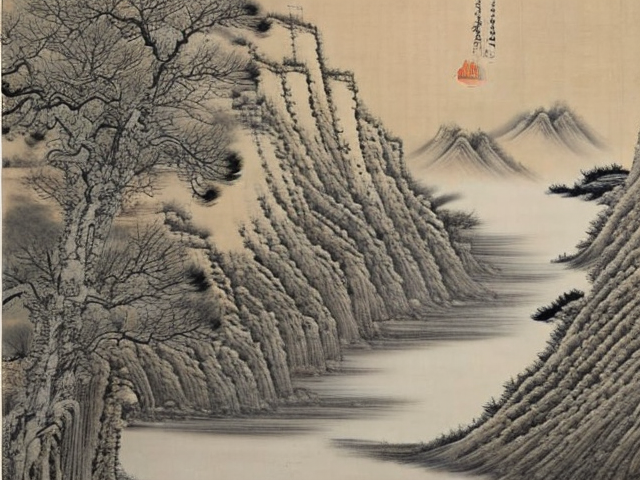

In [18]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Chinese painting of an winter cityscape",  # What to generate
    negative_prompt="clear, sharp, many thing",  # What NOT to generate
    height=480,
    width=640,  # Specify the image size
    guidance_scale=8,  # How strongly to follow the prompt
    num_inference_steps=35,  # How many steps to take
    generator=generator,  # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

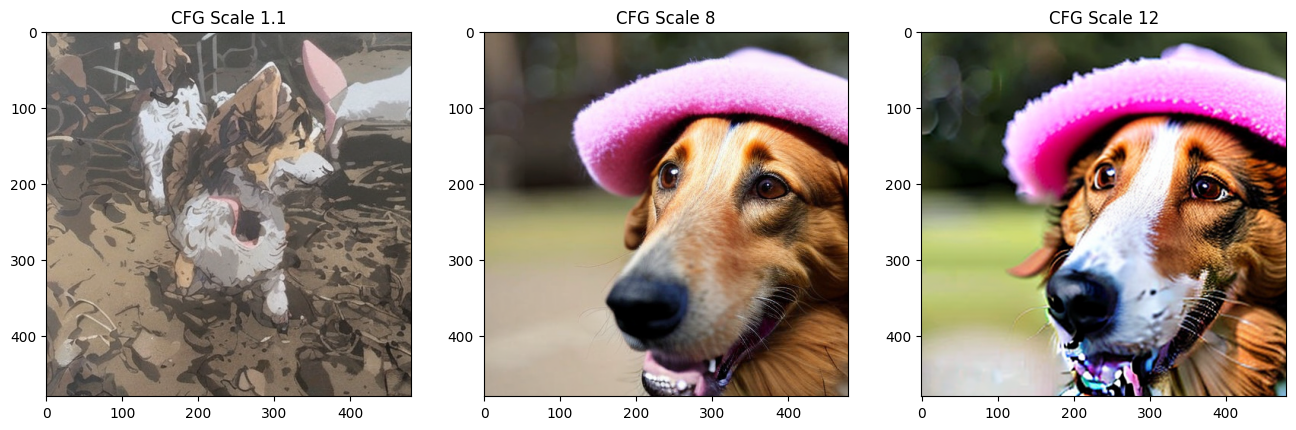

In [13]:
# @markdown comparing guidance scales:
cfg_scales = [1.1, 8, 12]  # @param
prompt = "A collie with a pink hat"  # @param
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
    im = pipe(
        prompt,
        height=480,
        width=480,
        guidance_scale=cfg_scales[i],
        num_inference_steps=35,
        generator=torch.Generator(device=device).manual_seed(42),
    ).images[0]
    ax.imshow(im)
    ax.set_title(f"CFG Scale {cfg_scales[i]}")